In [1]:
import tensorflow as tf 
import pandas as pd  
import numpy as np 
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import os
import pickle
from urllib.request import urlopen
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter

In [84]:
# defining path variables
root_dir=r'./'
test_data_path= root_dir+'data/test/'

In [3]:
# Downloading InceptionResNetV2 pretrained model on ImageNet dataset using Keras API
InceptionResNetV2=tf.keras.applications.InceptionResNetV2(
    include_top=True,
    weights="imagenet",
    pooling=None,
    classes=1000,
    classifier_activation="softmax"
)


In [5]:
test_images=os.listdir(test_data_path)
np.shape(test_images)

In [35]:
# Loading the test images in batches,
# Predicting the classes using the above model and saving the values in a dictionary.

batch_size=6895
steps=(len(test_images)//batch_size)
step=0
results={}
while(step<steps):

  # separating the batch from total data
  start=step*batch_size
  end=start+batch_size
  if end>len(test_images):
    end=len(test_images)
  batch=test_images[start:end]
  batch_images=[]

  # loading imgs
  for img in batch:
    img=image.load_img(test_data_path+str(img),target_size=(299,299,3))
    img=np.array(img)
    img=img/255
    batch_images.append(img)
  print(f'batch: {step+1}/{steps}')

  # predicting 
  batch_result=[]
  for img in batch_images:
    img=np.reshape(img,(1,299,299,3))
    result=InceptionResNetV2.predict(img)
    result=result.argmax(axis=-1)
    batch_result.append(result)
  for i in range(len(batch_result)):
    results[batch[i]]=batch_result[i]
  
  #next batch
  step+=1

batch: 1/1


In [85]:
# To convert the model output into human readable form we downloaded the classes dict used for ImageNet.
classes=pickle.load(urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl') )

# converting the results into a dataframe for better readability
results_df = pd.DataFrame(data=results.items(),columns=['imageId','label'])
results_df['class']=''
for i in range(len(results_df)):
  results_df['label'][i]=results_df['label'][i][0]
for i in range(len(results_df)):
  results_df['class'][i]=classes[results_df['label'][i]]

results_df.head()

,imageId,label,class
0,3001.jpg,578,gown
1,3002.jpg,578,gown
2,3003.jpg,697,"pajama, pyjama, pj's, jammies"
3,3004.jpg,638,maillot
4,3005.jpg,885,velvet


In [83]:
# Saving the output in a dataframe
results_df.to_csv('results_InceptionResNetV2.csv',index=False)

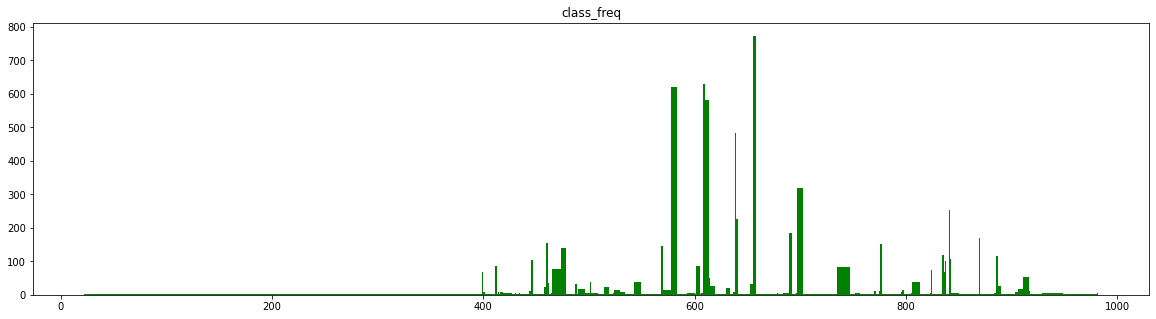

In [86]:
# A hist plot showing the frequency of classes in test dataset

fig=plt.figure(figsize=(20,5))
plt.title('class_freq')
bins=np.unique(results_df['label'])
plt.hist(results_df['label'],bins=bins, color='g')
plt.show()

In [79]:
# Counting Top ten classes in test dataset
class_freq=defaultdict(int)
for i in results_df['class']:
  class_freq[i]+=1
top_10_classes = dict(Counter(class_freq).most_common(10))

In [91]:
top_10_classes

{'miniskirt, mini': 773,
 'jean, blue jean, denim': 629,
 'gown': 620,
 'jersey, T-shirt, tee shirt': 583,
 'maillot': 484,
 "pajama, pyjama, pj's, jammies": 320,
 'sweatshirt': 252,
 'maillot, tank suit': 227,
 'overskirt': 184,
 'trench coat': 169}